In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
import seaborn as sns
import re
import geocoder
import osmread
import folium
import hyperopt
from transliterate import translit, get_available_language_codes
import time
import tqdm
import xgboost
from scipy.sparse import hstack

pd.options.display.max_columns=500

C:\Users\ssi_ao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
subm_example = pd.read_csv('sample_submission.csv',index_col='Id')

C:\Users\ssi_ao\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
subm_example.head()

,Times
Id,
0,1.922133
1,1.922133
2,1.922133
3,1.922133
4,1.922133


In [4]:
subm_example.shape

(1037875, 1)

# Загрузим данные и посмотрим на пароли.

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('Xtest.csv')

In [6]:
train.head()

,Password,Times
0,631XniVx2lS5I,2
1,LEGIT747,1
2,742364es,1
3,3846696477,1
4,laurahop,2


In [7]:
train.sort_values(by='Times').head(10)

,Password,Times
2075747,winhelp,1
2658537,hummel2,1
2658540,bojoalso,1
2658541,sanek9982110,1
2658542,anty_terror89,1
2658543,DREW43,1
2658544,ks06088,1
2658545,burtondu,1
2658546,1995tdf,1
2658549,113273,1


In [8]:
test.head()

,Id,Password
0,0,ThaisCunha
1,1,697775113
2,2,922a16922a
3,3,andy74
4,4,joemack


In [9]:
test.sample(5)

,Id,Password
854467,854467,5714
328458,328458,1fafyfcbq1
355761,355761,Virus123
266156,266156,neteh
284041,284041,nutyalc7


In [10]:
train[train['Times']>500].sort_values(by='Password').sample(15)

,Password,Times
299531,marina,1012
2619424,88888888,1243
3652249,maverick,1116
1257190,destiny,527
2024563,kitten,572
1995146,enter,860
1747604,letmein,3118
608073,555555,1591
829341,ncc1701,956
1595988,magic,577


In [11]:
test.sort_values(by='Password').head(15)

,Id,Password
348639,348639,!!!!!
1008186,1008186,!!!!%%
587665,587665,!!!**!
241467,241467,!!!111
182720,182720,!!!1980
634194,634194,!!!23mm
397222,397222,!!!4basketball
628320,628320,!!!@@@bulearca
219722,219722,!!!semen!!!
778001,778001,!!22!!


In [13]:
len(set(train['Password'])), len(train['Password']), len(set(test['Password'])), len(test['Password'])

(4151495, 4151496, 1037875, 1037875)

In [14]:
set(train['Password']).intersection(set(test['Password']))

{nan}

In [15]:
train['tr-ts']='tr'

test['Times']=0
test['tr-ts']='ts'

full_df = pd.concat([train,test.drop(columns='Id')],axis=0)

In [16]:
full_df.head()

,Password,Times,tr-ts
0,631XniVx2lS5I,2,tr
1,LEGIT747,1,tr
2,742364es,1,tr
3,3846696477,1,tr
4,laurahop,2,tr


In [17]:
full_df[full_df['tr-ts']=='ts'].head()

,Password,Times,tr-ts
0,ThaisCunha,0,ts
1,697775113,0,ts
2,922a16922a,0,ts
3,andy74,0,ts
4,joemack,0,ts


In [18]:
train.shape, test.shape, full_df.shape

((4151496, 3), (1037875, 4), (5189371, 3))

In [19]:
test.isnull().sum()

Id          0
Password    1
Times       0
tr-ts       0
dtype: int64

In [20]:
train.isnull().sum()

Password    2
Times       0
tr-ts       0
dtype: int64

In [21]:
train.describe()

,Times
count,4.151496e+06
mean,1.922133e+00
std,3.250090e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,5.589300e+04


In [22]:
train['log_target']=np.log1p(train['Times'])

In [23]:
train['log_target'].mean()

0.8177668865553219

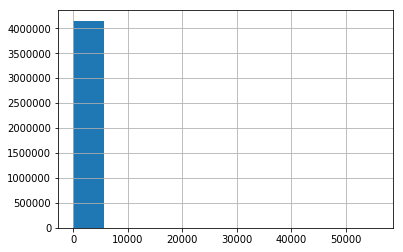

In [24]:
train['Times'].hist()

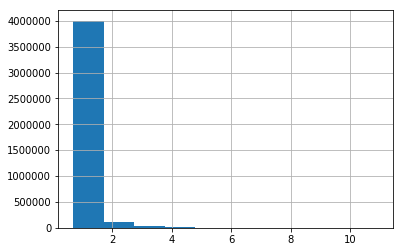

In [25]:
train['log_target'].hist()

In [26]:
train['log_target'].quantile(0.99)

2.833213344056216

In [27]:
train[train['log_target']<=train['log_target'].quantile(0.95)]['log_target'].mean()

0.7417793229124057

In [28]:
train.sort_values(by=['Times'],ascending=False).head(50)

,Password,Times,tr-ts,log_target
2715397,123456,55893,tr,10.931212
3136279,qwerty,13137,tr,9.483264
1175081,123456789,11696,tr,9.367088
2363307,12345,10938,tr,9.300090
2988373,1234,6432,tr,8.769196
2307329,111111,5682,tr,8.645235
3348280,1234567,4796,tr,8.475746
1795496,dragon,3927,tr,8.275886
3336606,123123,3845,tr,8.254789
3798071,baseball,3565,tr,8.179200


# BASELINE - MEAN

In [29]:
test['log_mean']=np.expm1(train['log_target'].mean())
answer=pd.DataFrame(data=test['log_mean'])
#answer.reset_index(inplace=True)
answer.columns=['Times']
answer.to_csv('mean.csv',index_label='Id')

# FEATURES - EXTRA_DATA. Файлики top-k-паролей.

In [30]:
full_df['Password'].fillna('NULL',inplace=True)

In [31]:
full_df.isnull().sum()

Password    0
Times       0
tr-ts       0
dtype: int64

In [32]:
full_df[full_df['tr-ts']=='tr']['Times'].min()

1

In [33]:
full_df['log_target']=np.log1p(full_df['Times'])

In [34]:
pwd_1 = pd.read_csv('pwd-1/10-million-password-list-top-100.txt',header=None)
pwd_1.columns=['Password']
pwd_1['top_100_pwd_cnt']=np.arange(pwd_1.shape[0])+1
pwd_1['top_100_pwd_cnt']=pwd_1['top_100_pwd_cnt'].astype(int)

pwd_2 = pd.read_csv('pwd-1/10-million-password-list-top-500.txt',header=None)
pwd_2.columns=['Password']
pwd_2['top_500_pwd_cnt']=np.arange(pwd_2.shape[0])+1
pwd_2['top_500_pwd_cnt']=pwd_2['top_500_pwd_cnt'].astype(int)

pwd_3 = pd.read_csv('pwd-1/10-million-password-list-top-1000.txt',header=None)
pwd_3.columns=['Password']
pwd_3['top_1000_pwd_cnt']=np.arange(pwd_3.shape[0])+1
pwd_3['top_1000_pwd_cnt']=pwd_3['top_1000_pwd_cnt'].astype(int)

pwd_4 = pd.read_csv('pwd-1/10-million-password-list-top-10000.txt',header=None)
pwd_4.columns=['Password']
pwd_4['top_10000_pwd_cnt']=np.arange(pwd_4.shape[0])+1
pwd_4['top_10000_pwd_cnt']=pwd_4['top_10000_pwd_cnt'].astype(int)

pwd_5 = pd.read_csv('pwd-1/10-million-password-list-top-100000.txt',header=None)
pwd_5.columns=['Password']
pwd_5['top_100000_pwd_cnt']=np.arange(pwd_5.shape[0])+1
pwd_5['top_100000_pwd_cnt']=pwd_5['top_100000_pwd_cnt'].astype(int)

pwd_6 = pd.read_csv('pwd-1/10-million-password-list-top-1000000.txt',header=None)
pwd_6.columns=['Password']
pwd_6['top_1000000_pwd_cnt']=np.arange(pwd_6.shape[0])+1
pwd_6['top_1000000_pwd_cnt']=pwd_6['top_1000000_pwd_cnt'].astype(int)

In [35]:
pwd_1.head(15)

,Password,top_100_pwd_cnt
0,123456,1
1,password,2
2,12345678,3
3,qwerty,4
4,123456789,5
5,12345,6
6,1234,7
7,111111,8
8,1234567,9
9,dragon,10


In [36]:
pwd_2.head(15)

,Password,top_500_pwd_cnt
0,123456,1
1,password,2
2,12345678,3
3,qwerty,4
4,123456789,5
5,12345,6
6,1234,7
7,111111,8
8,1234567,9
9,dragon,10


In [37]:
pwd_6.head(15)

,Password,top_1000000_pwd_cnt
0,123456,1
1,password,2
2,12345678,3
3,qwerty,4
4,123456789,5
5,12345,6
6,1234,7
7,111111,8
8,1234567,9
9,dragon,10


In [38]:
full_df=full_df.merge(pwd_1,how='left',on='Password').fillna(int(pwd_1.shape[0]*2))
full_df=full_df.merge(pwd_2,how='left',on='Password').fillna(int(pwd_2.shape[0]*2))
full_df=full_df.merge(pwd_3,how='left',on='Password').fillna(int(pwd_3.shape[0]*2))
full_df=full_df.merge(pwd_4,how='left',on='Password').fillna(int(pwd_4.shape[0]*2))
full_df=full_df.merge(pwd_5,how='left',on='Password').fillna(int(pwd_5.shape[0]*2))
full_df=full_df.merge(pwd_6,how='left',on='Password').fillna(int(pwd_6.shape[0]*2))

In [39]:
full_df.head()

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt
0,631XniVx2lS5I,2,tr,1.098612,200.0,1000.0,2000.0,20000.0,200000.0,675540.0
1,LEGIT747,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0
2,742364es,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0
3,3846696477,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0
4,laurahop,2,tr,1.098612,200.0,1000.0,2000.0,20000.0,200000.0,508058.0


# Признаки по паролям.

In [40]:
nums = set([str(x) for x in range(10)])

vow_sm = {'a','q','e','y','u','i','o'}
vow_big = {'A','Q','E','Y','U','I','O'}


spec = {'?','_','.', '@', '%', '!', '-', '*', '|', '$', '\\',']', '[', '~', '&', '^',
       '=', '+', '>', "'", ';', '`', '{', '(',')', '}','<','#','№'}

frequent_2 = ['qw','we','er','rt','as','sd','df','zx','xc','cv','12','23','34','45','56','67','78','89','90']
frequent_3 = ['qwe','asd','zxc','123','234','345','456','567','678','789','890']
frequent_4 = ['qwer','asdf','zxcv','1234','2345','3456','4567','5678','6789','7890']
frequent_5 = ['qwert','asdfg','zxcvb','12345','23456','34567','45678','56789','67890']
frequent_6 = ['qwerty','asdfgh','zxcvbn','poiuyt','123456','234567','345678','456789','567890']

In [41]:
from collections import Counter

In [42]:
full_df['len_pass']=full_df['Password'].apply(lambda x: len(str(x)))
full_df['len_num']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a in nums]))
full_df['len_upper']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a.isupper() and a not in nums and a not in spec]))
full_df['len_lower']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a.islower() and a not in nums and a not in spec]))
full_df['vow_low']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a in vow_sm]))
full_df['vow_up']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a in vow_big]))
full_df['spec']=full_df['Password'].apply(lambda x: np.sum([1 for a in str(x) if a in spec]))
full_df['unique']=full_df['Password'].apply(lambda x: len(Counter(str(x)).keys()))
full_df['max_len_unique']=full_df['Password'].apply(lambda x: np.max(list(Counter(str(x)).values())))

In [43]:
full_df['num_part']=full_df['len_num']/full_df['len_pass']
full_df['upper_part']=full_df['len_upper']/full_df['len_pass']
full_df['lower_part']=full_df['len_lower']/full_df['len_pass']
full_df['vow_total']=full_df['vow_low']+full_df['vow_up']
full_df['vow_low_part']=full_df['vow_up']/full_df['len_pass']
full_df['vow_up_part']=full_df['vow_low']/full_df['len_pass']
full_df['vow_total_part']=full_df['vow_total']/full_df['len_pass']
full_df['spec_part']=full_df['spec']/full_df['len_pass']
full_df['unique_part']=full_df['unique']/full_df['len_pass']
full_df['letter_per_unique']=full_df['len_pass']/full_df['unique']
full_df['unique_max_part']=full_df['max_len_unique']/full_df['len_pass']

In [44]:
full_df[full_df['tr-ts']=='tr']['Times'].min()

1

In [45]:
full_df['fr_2']=0
    
for f in frequent_2:
    full_df['fr_2']+=full_df['Password'].apply(lambda x: 1 if str(x).find(f)>=0 else 0)
    
full_df['fr_3']=0
    
for f in frequent_3:
    full_df['fr_3']+=full_df['Password'].apply(lambda x: 1 if str(x).find(f)>=0 else 0)
    
full_df['fr_4']=0
    
for f in frequent_4:
    full_df['fr_4']+=full_df['Password'].apply(lambda x: 1 if str(x).find(f)>=0 else 0)
    

full_df['fr_5']=0
    
for f in frequent_5:
    full_df['fr_5']+=full_df['Password'].apply(lambda x: 1 if str(x).find(f)>=0 else 0)
    
    
full_df['fr_6']=0
    
for f in frequent_6:
    full_df['fr_6']+=full_df['Password'].apply(lambda x: 1 if str(x).find(f)>=0 else 0)

In [46]:
full_df[full_df['tr-ts']=='tr']['Times'].min()

1

In [47]:
full_df[full_df['Password']=='qwerty']

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6
3136279,qwerty,13137,tr,9.483264,4.0,4.0,4.0,4.0,4.0,4.0,6,0.0,0.0,6.0,3.0,0.0,0.0,6,1,0.0,0.0,1.0,3.0,0.0,0.5,0.5,0.0,1.0,1.0,0.166667,4,1,1,1,1


In [48]:
full_df.sample(10)

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6
3477256,p7q6l,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,5,2.0,0.0,3.0,1.0,0.0,0.0,5,1,0.400000,0.000000,0.600000,1.0,0.000000,0.200000,0.200000,0.0,1.000000,1.000000,0.200000,0,0,0,0,0
2771122,illsyfmp,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,8,0.0,0.0,8.0,2.0,0.0,0.0,7,2,0.000000,0.000000,1.000000,2.0,0.000000,0.250000,0.250000,0.0,0.875000,1.142857,0.250000,0,0,0,0,0
2774507,mitos270979,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,11,6.0,0.0,5.0,2.0,0.0,0.0,9,2,0.545455,0.000000,0.454545,2.0,0.000000,0.181818,0.181818,0.0,0.818182,1.222222,0.181818,0,0,0,0,0
4854391,panzer88,0,ts,0.000000,200.0,1000.0,2000.0,20000.0,200000.0,136193.0,8,2.0,0.0,6.0,2.0,0.0,0.0,7,2,0.250000,0.000000,0.750000,2.0,0.000000,0.250000,0.250000,0.0,0.875000,1.142857,0.250000,1,0,0,0,0
2974419,frostmage,3,tr,1.386294,200.0,1000.0,2000.0,20000.0,200000.0,309684.0,9,0.0,0.0,9.0,3.0,0.0,0.0,9,1,0.000000,0.000000,1.000000,3.0,0.000000,0.333333,0.333333,0.0,1.000000,1.000000,0.111111,0,0,0,0,0
2378939,ishcpa2143,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,10,4.0,0.0,6.0,2.0,0.0,0.0,10,1,0.400000,0.000000,0.600000,2.0,0.000000,0.200000,0.200000,0.0,1.000000,1.000000,0.100000,0,0,0,0,0
4893335,jcanseco,0,ts,0.000000,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,8,0.0,0.0,8.0,3.0,0.0,0.0,7,2,0.000000,0.000000,1.000000,3.0,0.000000,0.375000,0.375000,0.0,0.875000,1.142857,0.250000,0,0,0,0,0
4492763,mansafety,0,ts,0.000000,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,9,0.0,0.0,9.0,4.0,0.0,0.0,8,2,0.000000,0.000000,1.000000,4.0,0.000000,0.444444,0.444444,0.0,0.888889,1.125000,0.222222,0,0,0,0,0
781565,NkxYZS,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,6,0.0,4.0,2.0,0.0,1.0,0.0,6,1,0.000000,0.666667,0.333333,1.0,0.166667,0.000000,0.166667,0.0,1.000000,1.000000,0.166667,0,0,0,0,0
3967146,1156aira,1,tr,0.693147,200.0,1000.0,2000.0,20000.0,200000.0,1999998.0,8,4.0,0.0,4.0,3.0,0.0,0.0,6,2,0.500000,0.000000,0.500000,3.0,0.000000,0.375000,0.375000,0.0,0.750000,1.333333,0.250000,1,0,0,0,0


In [49]:
full_df['first_char']=full_df['Password'].apply(lambda x: str(x)[0])

train_fc = set(full_df[full_df['tr-ts']=='tr']['first_char'].unique())
test_fc = set(full_df[full_df['tr-ts']=='ts']['first_char'].unique())
full_fc = train_fc.intersection(test_fc)

full_df['first_char']=full_df['first_char'].apply(lambda x: x if x in full_fc else 'other_fc')


rare_fc = full_df['first_char'].value_counts()[(full_df['first_char'].value_counts() < 30)==True].index

full_df['first_char']=full_df['first_char'].apply(lambda x: x if x not in rare_fc else 'rare_fc')

bl=list(full_df.groupby('first_char')[['log_target']].mean().sort_values(by='log_target').index)
d = {bl[i]: i for i in range(len(bl))}
full_df['first_char']=full_df['first_char'].map(d)

In [50]:
full_df['first_2_char']=full_df['Password'].apply(lambda x: str(x)[:2])

train_fc = set(full_df[full_df['tr-ts']=='tr']['first_2_char'].unique())
test_fc = set(full_df[full_df['tr-ts']=='ts']['first_2_char'].unique())
full_fc = train_fc.intersection(test_fc)

full_df['first_2_char']=full_df['first_2_char'].apply(lambda x: x if x in full_fc else 'other_2_fc')




rare_fc = full_df['first_2_char'].value_counts()[(full_df['first_2_char'].value_counts() < 30)==True].index

full_df['first_2_char']=full_df['first_2_char'].apply(lambda x: x if x not in rare_fc else 'rare_2_fc')

bl=list(full_df.groupby('first_2_char')[['log_target']].mean().sort_values(by='log_target').index)
d = {bl[i]: i for i in range(len(bl))}
full_df['first_2_char']=full_df['first_2_char'].map(d)

In [51]:
full_df['first_3_char']=full_df['Password'].apply(lambda x: str(x)[:3])

train_fc = set(full_df[full_df['tr-ts']=='tr']['first_3_char'].unique())
test_fc = set(full_df[full_df['tr-ts']=='ts']['first_3_char'].unique())
full_fc = train_fc.intersection(test_fc)

full_df['first_3_char']=full_df['first_3_char'].apply(lambda x: x if x in full_fc else 'other_3_fc')




rare_fc = full_df['first_3_char'].value_counts()[(full_df['first_3_char'].value_counts() < 30)==True].index

full_df['first_3_char']=full_df['first_3_char'].apply(lambda x: x if x not in rare_fc else 'rare_3_fc')

bl=list(full_df.groupby('first_3_char')[['log_target']].mean().sort_values(by='log_target').index)
d = {bl[i]: i for i in range(len(bl))}
full_df['first_3_char']=full_df['first_3_char'].map(d)

In [52]:
full_df[full_df['tr-ts']=='tr']['Times'].min()

1

In [53]:
full_df['top_100_pwd_cnt']=full_df['top_100_pwd_cnt'].astype(int)
full_df['top_500_pwd_cnt']=full_df['top_500_pwd_cnt'].astype(int)
full_df['top_1000_pwd_cnt']=full_df['top_1000_pwd_cnt'].astype(int)
full_df['top_10000_pwd_cnt']=full_df['top_10000_pwd_cnt'].astype(int)
full_df['top_100000_pwd_cnt']=full_df['top_100000_pwd_cnt'].astype(int)
full_df['top_1000000_pwd_cnt']=full_df['top_1000000_pwd_cnt'].astype(int)

In [54]:
full_df.dtypes

Password                object
Times                    int64
tr-ts                   object
log_target             float64
top_100_pwd_cnt          int32
top_500_pwd_cnt          int32
top_1000_pwd_cnt         int32
top_10000_pwd_cnt        int32
top_100000_pwd_cnt       int32
top_1000000_pwd_cnt      int32
len_pass                 int64
len_num                float64
len_upper              float64
len_lower              float64
vow_low                float64
vow_up                 float64
spec                   float64
unique                   int64
max_len_unique           int64
num_part               float64
upper_part             float64
lower_part             float64
vow_total              float64
vow_low_part           float64
vow_up_part            float64
vow_total_part         float64
spec_part              float64
unique_part            float64
letter_per_unique      float64
unique_max_part        float64
fr_2                     int64
fr_3                     int64
fr_4    

In [55]:
full_df.head()

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char
0,631XniVx2lS5I,2,tr,1.098612,200,1000,2000,20000,200000,675540,13,5.0,4.0,4.0,1.0,1.0,0.0,13,1,0.384615,0.307692,0.307692,2.0,0.076923,0.076923,0.153846,0.0,1.000,1.000000,0.076923,0,0,0,0,0,35,3049,12053
1,LEGIT747,1,tr,0.693147,200,1000,2000,20000,200000,1999998,8,3.0,5.0,0.0,0.0,2.0,0.0,7,2,0.375000,0.625000,0.000000,2.0,0.250000,0.000000,0.250000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,26,3146,17547
2,742364es,1,tr,0.693147,200,1000,2000,20000,200000,1999998,8,6.0,0.0,2.0,1.0,0.0,0.0,7,2,0.750000,0.000000,0.250000,1.0,0.000000,0.125000,0.125000,0.0,0.875,1.142857,0.250000,1,0,0,0,0,32,3373,10028
3,3846696477,1,tr,0.693147,200,1000,2000,20000,200000,1999998,10,10.0,0.0,0.0,0.0,0.0,0.0,6,3,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.600,1.666667,0.300000,0,0,0,0,0,57,3029,7930
4,laurahop,2,tr,1.098612,200,1000,2000,20000,200000,508058,8,0.0,0.0,8.0,4.0,0.0,0.0,7,2,0.000000,0.000000,1.000000,4.0,0.000000,0.500000,0.500000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,65,3719,16681


In [56]:
#Сохраним в отдельный файл готовый дата-фрейм
full_df.to_csv('full_df_new.csv',index=None)

# READ PREPARED DATA

In [57]:
types = {'Password':'str', 'Times':'int64', 'tr-ts':'str', 'log_target':'float64', 'top_100_pwd_cnt':'int16',
         'top_500_pwd_cnt':'int16','top_1000_pwd_cnt':'int16','top_10000_pwd_cnt':'int16','top_100000_pwd_cnt':'int16','top_1000000_pwd_cnt':'int16',
       'len_pass':'int16', 'len_num':'int16',
       'len_upper':'int16', 'len_lower':'int16', 'vow_low':'int16', 'vow_up':'int16', 'spec':'int16', 'unique':'int16',
       'max_len_unique':'int16', 'num_part':'float32', 'upper_part':'float32', 'lower_part':'float32', 'vow_total':'int16',
       'vow_low_part':'float32', 'vow_up_part':'float32', 'vow_total_part':'float32', 'spec_part':'float32',
       'unique_part':'float32', 'letter_per_unique':'float32', 'unique_max_part':'float32', 'fr_2':'int16', 'fr_3':'int16',
       'fr_4':'int16', 'fr_5':'int16', 'fr_6':'int16', 'first_char':'int16', 'first_2_char':'int16', 'first_3_char':'int16'}

In [58]:
full_df=pd.read_csv('full_df_new.csv',dtype=types)

In [59]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5189371 entries, 0 to 5189370
Data columns (total 38 columns):
Password               object
Times                  int64
tr-ts                  object
log_target             float64
top_100_pwd_cnt        int16
top_500_pwd_cnt        int16
top_1000_pwd_cnt       int16
top_10000_pwd_cnt      int16
top_100000_pwd_cnt     int16
top_1000000_pwd_cnt    int16
len_pass               int16
len_num                int16
len_upper              int16
len_lower              int16
vow_low                int16
vow_up                 int16
spec                   int16
unique                 int16
max_len_unique         int16
num_part               float32
upper_part             float32
lower_part             float32
vow_total              int16
vow_low_part           float32
vow_up_part            float32
vow_total_part         float32
spec_part              float32
unique_part            float32
letter_per_unique      float32
unique_max_part        f

In [60]:
full_df.sort_values(by='Times').head(5)

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char
5189370,ta3astu2,0,ts,0.0,200,1000,2000,20000,3392,13484,8,2,0,6,3,0,0,6,2,0.250000,0.0,0.750000,3,0.0,0.375000,0.375000,0.0,0.750000,1.333333,0.250000,1,0,0,0,0,64,3678,2013
4497459,ladasamar,0,ts,0.0,200,1000,2000,20000,3392,-31618,9,0,0,9,4,0,0,6,4,0.000000,0.0,1.000000,4,0.0,0.444444,0.444444,0.0,0.666667,1.500000,0.444444,1,0,0,0,0,65,3719,14916
4497458,1Safi,0,ts,0.0,200,1000,2000,20000,3392,-31618,5,1,1,3,2,0,0,5,1,0.200000,0.2,0.600000,2,0.0,0.400000,0.400000,0.0,1.000000,1.000000,0.200000,0,0,0,0,0,76,3866,15221
4497457,xand14,0,ts,0.0,200,1000,2000,20000,3392,-25417,6,2,0,4,1,0,0,6,1,0.333333,0.0,0.666667,1,0.0,0.166667,0.166667,0.0,1.000000,1.000000,0.166667,0,0,0,0,0,20,3214,15241
4497456,1427zk,0,ts,0.0,200,1000,2000,20000,3392,-31618,6,4,0,2,0,0,0,6,1,0.666667,0.0,0.333333,0,0.0,0.000000,0.000000,0.0,1.000000,1.000000,0.166667,0,0,0,0,0,76,3888,12794


In [61]:
full_df[full_df['tr-ts']=='tr']['log_target'].mean()

0.8177668865553219

In [62]:
full_df['Pass_list']=full_df['Password'].apply(lambda x: ','.join(str(x)))
full_df['Pass_list']=full_df['Pass_list'].apply(lambda x: x.split(','))

In [63]:
full_df.head()

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char,Pass_list
0,631XniVx2lS5I,2,tr,1.098612,200,1000,2000,20000,3392,20180,13,5,4,4,1,1,0,13,1,0.384615,0.307692,0.307692,2,0.076923,0.076923,0.153846,0.0,1.000,1.000000,0.076923,0,0,0,0,0,35,3049,12053,"[6, 3, 1, X, n, i, V, x, 2, l, S, 5, I]"
1,LEGIT747,1,tr,0.693147,200,1000,2000,20000,3392,-31618,8,3,5,0,0,2,0,7,2,0.375000,0.625000,0.000000,2,0.250000,0.000000,0.250000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,26,3146,17547,"[L, E, G, I, T, 7, 4, 7]"
2,742364es,1,tr,0.693147,200,1000,2000,20000,3392,-31618,8,6,0,2,1,0,0,7,2,0.750000,0.000000,0.250000,1,0.000000,0.125000,0.125000,0.0,0.875,1.142857,0.250000,1,0,0,0,0,32,3373,10028,"[7, 4, 2, 3, 6, 4, e, s]"
3,3846696477,1,tr,0.693147,200,1000,2000,20000,3392,-31618,10,10,0,0,0,0,0,6,3,1.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0.600,1.666667,0.300000,0,0,0,0,0,57,3029,7930,"[3, 8, 4, 6, 6, 9, 6, 4, 7, 7]"
4,laurahop,2,tr,1.098612,200,1000,2000,20000,3392,-16230,8,0,0,8,4,0,0,7,2,0.000000,0.000000,1.000000,4,0.000000,0.500000,0.500000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,65,3719,16681,"[l, a, u, r, a, h, o, p]"


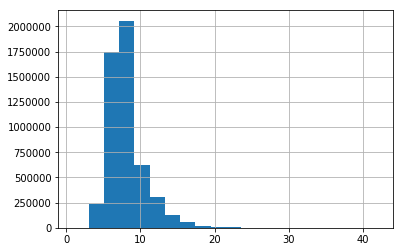

In [64]:
full_df['len_pass'].hist(bins=20)

# Добавим представление слов с помощью w2v

In [65]:
from gensim.models import word2vec

C:\Users\ssi_ao\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [66]:
model = word2vec.Word2Vec(list(full_df['Pass_list']), size=30, window=3, workers=4,sg=0,min_count=2,seed=1,compute_loss=True)
#создадим словарь со словами и соответсвующими им векторами
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

C:\Users\ssi_ao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [67]:
w2v['a']

array([ 1.0913194 ,  0.9291547 ,  0.63548076,  0.04842786,  2.1327016 ,
        0.39729628, -0.02879715,  0.05942145,  0.25294146, -0.5271462 ,
        0.62699413,  0.95922506,  0.31827894,  1.2852743 , -0.07421647,
        0.3624828 ,  0.17641082,  0.2786104 , -2.0292437 ,  1.733423  ,
        1.3048034 ,  0.10867355,  0.3712588 ,  1.4393315 ,  0.2633326 ,
        0.9979519 , -0.06630161, -1.9978404 ,  2.0556972 ,  0.85369307],
      dtype=float32)

In [68]:
model.most_similar(positive='q',topn=5)

C:\Users\ssi_ao\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('x', 0.7200225591659546),
 ('Q', 0.7109125256538391),
 ('z', 0.6959718465805054),
 ('w', 0.6648278832435608),
 ('X', 0.6432586908340454)]

In [69]:
#Слова можно просто усреднить

class mean_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(w2v.values())))
    
    def fit(self, X):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [70]:
#А можно сделать взвешенное усреднеднение

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class tfidf_vectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(w2v.values())))

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [15]:
data_mean=mean_vectorizer(w2v).fit(full_df['Pass_list']).transform(full_df['Pass_list'])
data_mean.shape

(5189371, 30)

In [71]:
data_mean = tfidf_vectorizer(w2v).fit(full_df['Pass_list']).transform(full_df['Pass_list'])
data_mean.shape

(5189371, 30)

In [72]:
data_mean[:,1].shape

(5189371,)

In [73]:
for i in range(data_mean.shape[1]):
    new_str = 'w2v_' + str(i)
    full_df[new_str]=data_mean[:,i]

In [74]:
full_df.head()

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char,Pass_list,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_17,w2v_18,w2v_19,w2v_20,w2v_21,w2v_22,w2v_23,w2v_24,w2v_25,w2v_26,w2v_27,w2v_28,w2v_29
0,631XniVx2lS5I,2,tr,1.098612,200,1000,2000,20000,3392,20180,13,5,4,4,1,1,0,13,1,0.384615,0.307692,0.307692,2,0.076923,0.076923,0.153846,0.0,1.000,1.000000,0.076923,0,0,0,0,0,35,3049,12053,"[6, 3, 1, X, n, i, V, x, 2, l, S, 5, I]",-7.912529,2.571976,-0.710289,-2.713608,-0.034336,-2.132729,4.514257,3.315495,-5.314758,0.396326,-2.237033,-3.588346,-1.176662,-2.641488,-1.605889,-2.849473,-3.428290,-6.177286,2.366500,-1.705999,7.763229,2.224623,-1.382846,-6.248780,-3.015791,-2.621526,3.015404,-0.250925,-2.002631,1.409374
1,LEGIT747,1,tr,0.693147,200,1000,2000,20000,3392,-31618,8,3,5,0,0,2,0,7,2,0.375000,0.625000,0.000000,2,0.250000,0.000000,0.250000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,26,3146,17547,"[L, E, G, I, T, 7, 4, 7]",-14.198511,6.327211,-1.491684,-4.288001,0.725960,-3.839735,7.243011,5.607963,-10.336779,1.427391,-2.821067,-6.715258,-2.049721,-5.823977,-3.170812,-4.991267,-8.912904,-15.234971,5.794827,-2.474224,14.542970,4.994579,-2.229131,-11.548429,-5.943622,-5.753935,7.793535,0.822730,-5.440894,3.792123
2,742364es,1,tr,0.693147,200,1000,2000,20000,3392,-31618,8,6,0,2,1,0,0,7,2,0.750000,0.000000,0.250000,1,0.000000,0.125000,0.125000,0.0,0.875,1.142857,0.250000,1,0,0,0,0,32,3373,10028,"[7, 4, 2, 3, 6, 4, e, s]",-1.019122,0.085140,0.181727,1.668598,-1.531918,-2.853720,-0.061180,-1.511448,0.385114,1.280071,-2.479937,-1.326360,-1.123589,-0.990386,0.600176,0.868648,-0.127694,-1.030073,1.452107,-0.894093,-1.482561,0.147179,0.016380,-1.634509,-1.080032,-1.318379,0.393041,5.273235,-2.770540,-1.587505
3,3846696477,1,tr,0.693147,200,1000,2000,20000,3392,-31618,10,10,0,0,0,0,0,6,3,1.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0.600,1.666667,0.300000,0,0,0,0,0,57,3029,7930,"[3, 8, 4, 6, 6, 9, 6, 4, 7, 7]",-1.769881,0.241867,0.757559,1.956296,-2.699587,-4.693933,-0.080233,-1.925930,0.178432,0.763944,-4.365849,-2.750574,-2.627449,-2.226387,0.272564,1.737370,-0.526773,-2.029075,3.702644,-2.869916,-3.795476,-0.294393,-0.728741,-3.168075,-2.047660,-2.966379,0.264157,9.669775,-5.921934,-2.940889
4,laurahop,2,tr,1.098612,200,1000,2000,20000,3392,-16230,8,0,0,8,4,0,0,7,2,0.000000,0.000000,1.000000,4,0.000000,0.500000,0.500000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,65,3719,16681,"[l, a, u, r, a, h, o, p]",1.062504,0.416487,-1.017113,-1.641359,2.724756,2.263304,0.807831,0.917618,-0.258757,0.233665,3.247582,2.787256,1.402736,2.949416,0.155742,-1.475318,0.106219,0.733148,-3.637964,2.553314,2.600069,-0.024262,0.806073,1.645000,1.032227,2.578681,-0.067253,-6.418888,5.007923,3.049910


In [75]:
X_train = full_df[full_df['tr-ts']=='tr'].drop(columns=['Password','Times','tr-ts','log_target','Pass_list'])
y_train_log = full_df[full_df['tr-ts']=='tr']['log_target']
y_train =full_df[full_df['tr-ts']=='tr']['Times']
#X_train=hstack([X_train.values,tv_pass[:y_train.shape[0],:]])


X_test = full_df[full_df['tr-ts']=='ts'].drop(columns=['Password','Times','tr-ts','log_target','Pass_list'])
#X_test=hstack([X_test.values,tv_pass[y_train.shape[0]:,:]])

In [76]:
X_train.head()

,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_17,w2v_18,w2v_19,w2v_20,w2v_21,w2v_22,w2v_23,w2v_24,w2v_25,w2v_26,w2v_27,w2v_28,w2v_29
0,200,1000,2000,20000,3392,20180,13,5,4,4,1,1,0,13,1,0.384615,0.307692,0.307692,2,0.076923,0.076923,0.153846,0.0,1.000,1.000000,0.076923,0,0,0,0,0,35,3049,12053,-7.912529,2.571976,-0.710289,-2.713608,-0.034336,-2.132729,4.514257,3.315495,-5.314758,0.396326,-2.237033,-3.588346,-1.176662,-2.641488,-1.605889,-2.849473,-3.428290,-6.177286,2.366500,-1.705999,7.763229,2.224623,-1.382846,-6.248780,-3.015791,-2.621526,3.015404,-0.250925,-2.002631,1.409374
1,200,1000,2000,20000,3392,-31618,8,3,5,0,0,2,0,7,2,0.375000,0.625000,0.000000,2,0.250000,0.000000,0.250000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,26,3146,17547,-14.198511,6.327211,-1.491684,-4.288001,0.725960,-3.839735,7.243011,5.607963,-10.336779,1.427391,-2.821067,-6.715258,-2.049721,-5.823977,-3.170812,-4.991267,-8.912904,-15.234971,5.794827,-2.474224,14.542970,4.994579,-2.229131,-11.548429,-5.943622,-5.753935,7.793535,0.822730,-5.440894,3.792123
2,200,1000,2000,20000,3392,-31618,8,6,0,2,1,0,0,7,2,0.750000,0.000000,0.250000,1,0.000000,0.125000,0.125000,0.0,0.875,1.142857,0.250000,1,0,0,0,0,32,3373,10028,-1.019122,0.085140,0.181727,1.668598,-1.531918,-2.853720,-0.061180,-1.511448,0.385114,1.280071,-2.479937,-1.326360,-1.123589,-0.990386,0.600176,0.868648,-0.127694,-1.030073,1.452107,-0.894093,-1.482561,0.147179,0.016380,-1.634509,-1.080032,-1.318379,0.393041,5.273235,-2.770540,-1.587505
3,200,1000,2000,20000,3392,-31618,10,10,0,0,0,0,0,6,3,1.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.0,0.600,1.666667,0.300000,0,0,0,0,0,57,3029,7930,-1.769881,0.241867,0.757559,1.956296,-2.699587,-4.693933,-0.080233,-1.925930,0.178432,0.763944,-4.365849,-2.750574,-2.627449,-2.226387,0.272564,1.737370,-0.526773,-2.029075,3.702644,-2.869916,-3.795476,-0.294393,-0.728741,-3.168075,-2.047660,-2.966379,0.264157,9.669775,-5.921934,-2.940889
4,200,1000,2000,20000,3392,-16230,8,0,0,8,4,0,0,7,2,0.000000,0.000000,1.000000,4,0.000000,0.500000,0.500000,0.0,0.875,1.142857,0.250000,0,0,0,0,0,65,3719,16681,1.062504,0.416487,-1.017113,-1.641359,2.724756,2.263304,0.807831,0.917618,-0.258757,0.233665,3.247582,2.787256,1.402736,2.949416,0.155742,-1.475318,0.106219,0.733148,-3.637964,2.553314,2.600069,-0.024262,0.806073,1.645000,1.032227,2.578681,-0.067253,-6.418888,5.007923,3.049910


In [77]:
X_test.head()

,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_17,w2v_18,w2v_19,w2v_20,w2v_21,w2v_22,w2v_23,w2v_24,w2v_25,w2v_26,w2v_27,w2v_28,w2v_29
4151496,200,1000,2000,20000,3392,-31618,10,0,2,8,4,0,0,8,2,0.000000,0.2,0.800000,4,0.0,0.400000,0.400000,0.0,0.800000,1.25,0.200000,0,0,0,0,0,31,3438,8129,-3.326869,1.612077,-0.607564,-3.240583,2.384840,1.166310,1.886174,2.075052,-3.552626,0.065534,1.667719,0.763230,0.454525,1.314440,-1.164993,-2.712535,-2.538158,-3.649616,-2.260508,1.926007,6.947890,1.839813,-0.143082,-1.753479,-0.818291,1.051545,1.915986,-6.089570,3.278457,4.419730
4151497,200,1000,2000,20000,3392,-31618,9,9,0,0,0,0,0,6,3,1.000000,0.0,0.000000,0,0.0,0.000000,0.000000,0.0,0.666667,1.50,0.333333,0,0,0,0,0,35,3532,13246,-1.192675,0.666013,0.383726,2.475672,-2.214902,-4.444943,-0.254308,-2.047951,-0.149923,0.529827,-3.494826,-1.728433,-2.317908,-2.036479,0.228285,1.930837,-0.632676,-2.056975,3.008855,-2.216644,-3.787855,-0.294991,-0.995485,-2.455598,-2.075637,-2.510586,0.176564,8.955175,-5.525017,-2.942010
4151498,200,1000,2000,20000,3392,-31618,10,8,0,2,2,0,0,5,4,0.800000,0.0,0.200000,2,0.0,0.200000,0.200000,0.0,0.500000,2.00,0.400000,0,0,0,0,0,29,3078,8169,-0.174005,0.937772,0.764235,2.526667,-1.167325,-3.055315,-0.093777,-0.884389,0.179380,0.442550,-1.782449,-0.763437,-1.195958,-0.908556,0.695037,1.662256,-0.381594,-1.078056,0.649378,-0.459869,-2.280840,-0.043599,-0.853250,-0.892109,-1.861581,-1.214237,-0.057780,6.380052,-2.964490,-1.800103
4151499,200,1000,2000,20000,3392,-31618,6,2,0,4,2,0,0,6,1,0.333333,0.0,0.666667,2,0.0,0.333333,0.333333,0.0,1.000000,1.00,0.166667,0,0,0,0,0,56,3621,12127,-0.789046,0.201523,-0.239454,-0.667595,0.520754,0.355829,0.213700,-0.028339,-0.531175,-0.127493,0.011131,0.991044,0.366457,0.551800,-0.663775,0.097905,-0.206417,0.236010,-0.111253,0.528093,0.463845,0.091486,0.391543,0.777995,-0.787001,1.233828,0.070200,-0.722045,0.683199,1.052147
4151500,200,1000,2000,20000,3392,-29306,7,0,0,7,3,0,0,7,1,0.000000,0.0,1.000000,3,0.0,0.428571,0.428571,0.0,1.000000,1.00,0.142857,0,0,0,0,0,60,3699,13197,0.052334,0.850656,-0.304327,-2.369540,2.282734,4.033727,0.299031,0.582030,-0.541785,-0.310042,1.985730,1.747636,1.399985,1.995660,-0.935869,-0.569602,-0.274053,0.855633,-3.617879,2.424638,2.033049,0.632905,0.327453,1.866604,0.479103,3.506029,-0.167507,-5.608723,4.977456,2.814843


In [79]:
X_train.shape, X_test.shape

((4151496, 64), (1037875, 64))

In [78]:
full_df[full_df['tr-ts']=='tr'].sort_values(by='Times').head()

,Password,Times,tr-ts,log_target,top_100_pwd_cnt,top_500_pwd_cnt,top_1000_pwd_cnt,top_10000_pwd_cnt,top_100000_pwd_cnt,top_1000000_pwd_cnt,len_pass,len_num,len_upper,len_lower,vow_low,vow_up,spec,unique,max_len_unique,num_part,upper_part,lower_part,vow_total,vow_low_part,vow_up_part,vow_total_part,spec_part,unique_part,letter_per_unique,unique_max_part,fr_2,fr_3,fr_4,fr_5,fr_6,first_char,first_2_char,first_3_char,Pass_list,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,w2v_11,w2v_12,w2v_13,w2v_14,w2v_15,w2v_16,w2v_17,w2v_18,w2v_19,w2v_20,w2v_21,w2v_22,w2v_23,w2v_24,w2v_25,w2v_26,w2v_27,w2v_28,w2v_29
2075747,winhelp,1,tr,0.693147,200,1000,2000,20000,3392,9257,7,0,0,7,2,0,0,7,1,0.000000,0.0,1.000000,2,0.0,0.285714,0.285714,0.000000,1.000000,1.000000,0.142857,0,0,0,0,0,66,3834,17332,"[w, i, n, h, e, l, p]",-0.084379,0.044991,-1.993753,-2.166655,1.900588,1.574047,1.086440,1.120888,-0.364276,0.403317,3.283933,2.252637,2.019679,3.324992,-0.362488,-2.261897,0.242907,0.879586,-2.938394,2.950032,3.131276,0.536765,0.569077,1.600608,0.866347,2.650055,0.504173,-7.015474,5.513272,2.113503
2658537,hummel2,1,tr,0.693147,200,1000,2000,20000,3392,-31618,7,1,0,6,2,0,0,6,2,0.142857,0.0,0.857143,2,0.0,0.285714,0.285714,0.000000,0.857143,1.166667,0.285714,0,0,0,0,0,70,3720,16849,"[h, u, m, m, e, l, 2]",0.480498,0.485439,-1.125336,-0.827618,1.320737,1.841076,0.572668,1.001092,-0.759711,0.135894,2.032342,2.653104,0.889149,2.879426,0.149394,-1.077845,-0.014694,0.736564,-2.819649,2.220666,1.909562,0.473426,0.559628,0.940822,-0.078247,2.413852,-0.064794,-4.615141,3.493325,2.343564
2658540,bojoalso,1,tr,0.693147,200,1000,2000,20000,3392,-31618,8,0,0,8,4,0,0,6,3,0.000000,0.0,1.000000,4,0.0,0.500000,0.500000,0.000000,0.750000,1.333333,0.375000,0,0,0,0,0,74,3818,10364,"[b, o, j, o, a, l, s, o]",0.354202,0.352476,-0.125948,-2.063322,2.801321,3.662374,0.799576,0.492306,-0.039555,0.335711,2.780739,1.968404,2.223152,2.112021,-0.315558,-0.365529,-0.230002,0.768713,-3.194761,2.969568,1.743107,-0.026546,0.437664,2.585894,0.367437,2.900380,0.080650,-6.543592,4.539899,3.252193
2658541,sanek9982110,1,tr,0.693147,200,1000,2000,20000,3392,-31618,12,7,0,5,2,0,0,10,2,0.583333,0.0,0.416667,2,0.0,0.166667,0.166667,0.000000,0.833333,1.200000,0.166667,0,0,0,0,0,73,3789,15432,"[s, a, n, e, k, 9, 9, 8, 2, 1, 1, 0]",0.391028,0.932518,-0.085090,1.566211,-0.340831,-1.733350,-0.194079,-0.398883,-0.509861,0.026322,-0.001853,0.411367,-0.348590,0.126069,0.459754,1.126908,-0.352829,-0.811067,-0.597766,0.703616,-1.719612,0.144870,-0.744522,-0.381727,-1.715712,0.108766,-0.198907,3.093152,-0.895567,-0.693185
2658542,anty_terror89,1,tr,0.693147,200,1000,2000,20000,3392,-31618,13,2,0,10,4,0,1,10,3,0.153846,0.0,0.769231,4,0.0,0.307692,0.307692,0.076923,0.769231,1.300000,0.230769,2,0,0,0,0,56,3621,11255,"[a, n, t, y, _, t, e, r, r, o, r, 8, 9]",0.623315,0.642952,-0.643284,-1.268516,2.020635,0.765955,0.846166,-0.015015,-1.295547,-0.655078,2.891410,2.471058,1.831976,1.599483,0.731334,-1.004734,-0.168460,0.226352,-2.877664,2.254834,1.810131,-0.062108,1.445619,1.642789,-1.491239,1.740239,-0.969688,-4.105756,3.181752,2.146392


In [80]:
del full_df

In [81]:
import gc

In [82]:
gc.collect()

0

In [83]:
#Немного тюнинга

lg_params= {'learning_rate':0.1,
        'random_state':15,
        'n_jobs':4,
        'subsample':0.2,
        'colsample_bytree':0.8,
        'num_leaves':88,
        'reg_alpha':5,
        'reg_lambda':5,
        'min_child_samples':10,
        'objective':'regression'}


#X_train=X_train[y_train_log<np.quantile(y_train_log,0.975)]
#y_train_log=y_train_log[y_train_log<np.quantile(y_train_log,0.975)]
lg_train= lgb.Dataset(X_train, y_train_log)

In [84]:
cv_result=lgb.cv(lg_params, lg_train,num_boost_round=1000,nfold=4,stratified=False,metrics='rmse',early_stopping_rounds=50,verbose_eval=True,seed=2003,shuffle=True)

[1]	cv_agg's rmse: 0.372362 + 0.000360917
[2]	cv_agg's rmse: 0.339519 + 0.000344189
[3]	cv_agg's rmse: 0.310296 + 0.000368094
[4]	cv_agg's rmse: 0.29061 + 0.00037601
[5]	cv_agg's rmse: 0.266728 + 0.000382807
[6]	cv_agg's rmse: 0.245389 + 0.00040277
[7]	cv_agg's rmse: 0.22724 + 0.000389102
[8]	cv_agg's rmse: 0.210835 + 0.000350915
[9]	cv_agg's rmse: 0.20763 + 0.000378476
[10]	cv_agg's rmse: 0.193303 + 0.000453511
[11]	cv_agg's rmse: 0.180902 + 0.000512635
[12]	cv_agg's rmse: 0.173356 + 0.000520827
[13]	cv_agg's rmse: 0.163301 + 0.000518662
[14]	cv_agg's rmse: 0.154137 + 0.000303606
[15]	cv_agg's rmse: 0.147839 + 0.00028759
[16]	cv_agg's rmse: 0.143507 + 0.000310473
[17]	cv_agg's rmse: 0.142483 + 0.000304942
[18]	cv_agg's rmse: 0.137171 + 0.000314016
[19]	cv_agg's rmse: 0.131471 + 0.000469707
[20]	cv_agg's rmse: 0.126391 + 0.000531959
[21]	cv_agg's rmse: 0.121871 + 0.000556707
[22]	cv_agg's rmse: 0.118742 + 0.000606679
[23]	cv_agg's rmse: 0.115912 + 0.000568815
[24]	cv_agg's rmse: 0.1127

[187]	cv_agg's rmse: 0.0678914 + 0.000490029
[188]	cv_agg's rmse: 0.0678229 + 0.000515369
[189]	cv_agg's rmse: 0.0677721 + 0.000519821
[190]	cv_agg's rmse: 0.0677105 + 0.000532133
[191]	cv_agg's rmse: 0.0676499 + 0.000500879
[192]	cv_agg's rmse: 0.0676114 + 0.000502838
[193]	cv_agg's rmse: 0.0675435 + 0.0005312
[194]	cv_agg's rmse: 0.067519 + 0.00053195
[195]	cv_agg's rmse: 0.067415 + 0.000566115
[196]	cv_agg's rmse: 0.067399 + 0.00056292
[197]	cv_agg's rmse: 0.0672953 + 0.000554625
[198]	cv_agg's rmse: 0.0672516 + 0.000551035
[199]	cv_agg's rmse: 0.067142 + 0.000596354
[200]	cv_agg's rmse: 0.0670867 + 0.000553272
[201]	cv_agg's rmse: 0.0669858 + 0.000580125
[202]	cv_agg's rmse: 0.06693 + 0.000550478
[203]	cv_agg's rmse: 0.0668892 + 0.000556006
[204]	cv_agg's rmse: 0.0668214 + 0.000533459
[205]	cv_agg's rmse: 0.0668074 + 0.000534234
[206]	cv_agg's rmse: 0.0667954 + 0.000529704
[207]	cv_agg's rmse: 0.0666979 + 0.000524228
[208]	cv_agg's rmse: 0.0665269 + 0.000550088
[209]	cv_agg's rmse:

[370]	cv_agg's rmse: 0.0589477 + 0.000332565
[371]	cv_agg's rmse: 0.0589138 + 0.000333518
[372]	cv_agg's rmse: 0.0588733 + 0.000355418
[373]	cv_agg's rmse: 0.0588615 + 0.000347254
[374]	cv_agg's rmse: 0.0588297 + 0.000359452
[375]	cv_agg's rmse: 0.0588133 + 0.000366517
[376]	cv_agg's rmse: 0.0587824 + 0.000354643
[377]	cv_agg's rmse: 0.0587464 + 0.000342364
[378]	cv_agg's rmse: 0.0586939 + 0.00037004
[379]	cv_agg's rmse: 0.0586881 + 0.000365819
[380]	cv_agg's rmse: 0.0586706 + 0.000371002
[381]	cv_agg's rmse: 0.0586293 + 0.000373445
[382]	cv_agg's rmse: 0.0585627 + 0.000320934
[383]	cv_agg's rmse: 0.058535 + 0.000330271
[384]	cv_agg's rmse: 0.0585283 + 0.000333949
[385]	cv_agg's rmse: 0.058465 + 0.000356784
[386]	cv_agg's rmse: 0.0584462 + 0.000357698
[387]	cv_agg's rmse: 0.0584107 + 0.000341232
[388]	cv_agg's rmse: 0.0583996 + 0.00034338
[389]	cv_agg's rmse: 0.0583872 + 0.000345728
[390]	cv_agg's rmse: 0.0583608 + 0.000339003
[391]	cv_agg's rmse: 0.0583248 + 0.00032874
[392]	cv_agg's 

[552]	cv_agg's rmse: 0.0545478 + 0.000303712
[553]	cv_agg's rmse: 0.0545475 + 0.000303309
[554]	cv_agg's rmse: 0.0545287 + 0.000308144
[555]	cv_agg's rmse: 0.0544918 + 0.000314637
[556]	cv_agg's rmse: 0.0544903 + 0.000314205
[557]	cv_agg's rmse: 0.0544553 + 0.000308962
[558]	cv_agg's rmse: 0.0544388 + 0.000291362
[559]	cv_agg's rmse: 0.0543637 + 0.000300363
[560]	cv_agg's rmse: 0.0543582 + 0.000297473
[561]	cv_agg's rmse: 0.0543334 + 0.00029682
[562]	cv_agg's rmse: 0.0543121 + 0.000296127
[563]	cv_agg's rmse: 0.0542655 + 0.000292315
[564]	cv_agg's rmse: 0.0542494 + 0.000304162
[565]	cv_agg's rmse: 0.054217 + 0.000320534
[566]	cv_agg's rmse: 0.0542008 + 0.000317132
[567]	cv_agg's rmse: 0.0541864 + 0.000327042
[568]	cv_agg's rmse: 0.0541698 + 0.000336381
[569]	cv_agg's rmse: 0.0541472 + 0.000342056
[570]	cv_agg's rmse: 0.054132 + 0.000341428
[571]	cv_agg's rmse: 0.0541184 + 0.000345158
[572]	cv_agg's rmse: 0.0541005 + 0.00035493
[573]	cv_agg's rmse: 0.0540851 + 0.000358315
[574]	cv_agg's

[734]	cv_agg's rmse: 0.0515911 + 0.000360446
[735]	cv_agg's rmse: 0.0515805 + 0.000359889
[736]	cv_agg's rmse: 0.051572 + 0.000354785
[737]	cv_agg's rmse: 0.0515552 + 0.000360847
[738]	cv_agg's rmse: 0.0515504 + 0.000363273
[739]	cv_agg's rmse: 0.0515285 + 0.000377364
[740]	cv_agg's rmse: 0.0515152 + 0.000382144
[741]	cv_agg's rmse: 0.0514796 + 0.000398114
[742]	cv_agg's rmse: 0.0514678 + 0.000391961
[743]	cv_agg's rmse: 0.0514669 + 0.000391822
[744]	cv_agg's rmse: 0.0514651 + 0.000391756
[745]	cv_agg's rmse: 0.0514305 + 0.000396558
[746]	cv_agg's rmse: 0.0514267 + 0.000400228
[747]	cv_agg's rmse: 0.0514232 + 0.000399805
[748]	cv_agg's rmse: 0.0513952 + 0.000406384
[749]	cv_agg's rmse: 0.0513679 + 0.000413346
[750]	cv_agg's rmse: 0.0513461 + 0.000403437
[751]	cv_agg's rmse: 0.0513355 + 0.000404168
[752]	cv_agg's rmse: 0.0513311 + 0.000407957
[753]	cv_agg's rmse: 0.0513193 + 0.00041439
[754]	cv_agg's rmse: 0.0513121 + 0.000413203
[755]	cv_agg's rmse: 0.051293 + 0.000424382
[756]	cv_agg'

[916]	cv_agg's rmse: 0.0493778 + 0.000233875
[917]	cv_agg's rmse: 0.0493692 + 0.000231779
[918]	cv_agg's rmse: 0.0493636 + 0.000232976
[919]	cv_agg's rmse: 0.0493465 + 0.000234419
[920]	cv_agg's rmse: 0.049338 + 0.000230988
[921]	cv_agg's rmse: 0.0493309 + 0.000231917
[922]	cv_agg's rmse: 0.0493299 + 0.000230688
[923]	cv_agg's rmse: 0.0493277 + 0.000231792
[924]	cv_agg's rmse: 0.0493239 + 0.000232465
[925]	cv_agg's rmse: 0.0493132 + 0.000223485
[926]	cv_agg's rmse: 0.0492892 + 0.000214086
[927]	cv_agg's rmse: 0.0492738 + 0.000219201
[928]	cv_agg's rmse: 0.0492716 + 0.000219861
[929]	cv_agg's rmse: 0.0492478 + 0.00020605
[930]	cv_agg's rmse: 0.0492244 + 0.000218608
[931]	cv_agg's rmse: 0.0492115 + 0.00022181
[932]	cv_agg's rmse: 0.0491984 + 0.000224566
[933]	cv_agg's rmse: 0.0491852 + 0.00022646
[934]	cv_agg's rmse: 0.0491741 + 0.000227011
[935]	cv_agg's rmse: 0.0491691 + 0.000230541
[936]	cv_agg's rmse: 0.0491636 + 0.000235415
[937]	cv_agg's rmse: 0.0491562 + 0.000238162
[938]	cv_agg's

In [85]:
#Оставим 1000 деревьев

lg = lgb.LGBMRegressor(**lg_params, n_estimators=1000)

In [86]:
lg.fit(X_train,y_train_log)
y_pred = lg.predict(X_test)

In [87]:
y_pred.min()

0.5937730932612882

In [88]:
np.log1p(1)

0.6931471805599453

In [89]:
#9 место на привате

answer=pd.DataFrame(data=y_pred)
answer.columns=['Times']
answer['Times']=answer['Times'].apply(lambda x: np.log1p(1) if x < np.log1p(1) else x)
answer.reset_index(drop=True,inplace=True)
answer['Times']=np.expm1(answer['Times'])
answer.to_csv('9_place.csv',index_label='Id')